This notebooks contains code to evaluate SISTR2 selection inferences based on varying numbers of input STR loci. These plots  show the mean estimated s +/- 1 s.d.

In [1]:
%pylab inline
import glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Simulation_functions import *
from Joint_method_functions import *
from Per_locus_validation_functions import *
PLOTDIR = '/storage/BonnieH/selection_project/figures/supp_figures/'
from scipy.stats import sem

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_mean(folder, per, opt, mean, file_num):
    file_list = glob.glob('/gymreklab-tscc/bonnieh/joint_method/results_validation_top_x/%s/per_%d_opt_%d_*_%.8f.txt'%(folder, per, opt, mean)) #31
    file_list.sort()
                    
    filename = file_list[file_num]
                        
    allele_freqs_file = open(filename, 'r')
    lines = allele_freqs_file.readlines()

    line = lines[12]
    info = line.strip().split(': ')
    stats = info[1]
    info = stats.strip().split(',')
    list_of_medians = []
    for elem in info:
        list_of_medians.append(np.log10(float(elem)))
    mean = np.mean(list_of_medians)
    stdmean = np.std(list_of_medians)
                    
    line = lines[1]
    info = line.strip().split(' ')
    k = float(info[7])
    theta = float(info[10])
    
    allele_freqs_file.close()
    return mean, stdmean, k, theta

In [3]:
def main():
    
    means = [10**-5, 10**-4, 10**-3, 10**-2] 
    #means = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
    #means = [10**-5, 10**-4.5, 10**-4, 10**-3.5, 10**-3, 10**-2.5, 10**-2]
    per_opt_combos = [(2,11),(3,5),(3,13)]#,(2,20),(4,7),(4,10)]
    color_list = ['deepskyblue','blue','lightgreen','green','lightpink','deeppink','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    fig_num = 0
    plot_med = True
    fig_num = fig_num + 1
    color_num = -1
    file_num = 2
    
    mut_params_dic = {}
    mut_params_dic[(3,5)] = 'Period 3 Optimal allele 5: Baseline mutation rate 10^-5.5' #, p=0.9, L=0.33'
    mut_params_dic[(3,13)] = 'Period 3 Optimal allele 13: Baseline mutation rate 10^-3' #, p=0.9, L=0.33'
    mut_params_dic[(2,11)] = 'Period 2 Optimal allele 11: Baseline mutation rate 10^-4.25' #, p=0.6, L=0.15'
    mut_params_dic[(2,20)] = 'Period 2 Optimal allele 20: Baseline mutation rate 10^-3'#'mu=10^-3, p=0.6, L=0.15'
    mut_params_dic[(4,7)] = 'Period 4 Optimal allele 7: Baseline mutation rate 10^-4.2'#'mu=10^-4.2, p=0.9, L=0.45'
    mut_params_dic[(4,10)] = 'Period 4 Optimal allele 10: Baseline mutation rate 10^-3'#'mu=10^-3, p=0.9, L=0.45'
    
    # Parameters
    model = 'eurodem_prior2'
    eps_het_numerator = 0.005
    eps_het_denominator =3
    eps_bins=0.3
    constant_common = 1
    denom_common = 1
    use_het = 'y'
    use_common = 'n'
    use_bins = 'y'
    num_bins = 5

    # Preprocess simulation lookup table
    # Get simulation tables
    sim_tables = {}
    ABC_tables = {}
    for per_opt_combo in per_opt_combos:

        file = '/gymreklab-tscc/bonnieh/abc/results/' + model + '/' + str(per_opt_combo[0]) + '_' + str(per_opt_combo[1]) + '.txt'  
        table = GetABCList(file, num_bins)
        dic_summ_stats = {}

        # Fill in dic_summ_stats: Key is s, value is list of (het, number of common alleles, bins) for given s value
        for combo in table:
            s_round = get_LRT_bin(combo[0])
            if s_round not in dic_summ_stats:
                dic_summ_stats[s_round] = []
            dic_summ_stats[s_round].append(combo[3]) # Append het, number of common alleles, bins for s value

        sim_tables[per_opt_combo] = dic_summ_stats

        # Preprocess ABC lookup table
        # Get ABC tables
        
        ABC_tables[per_opt_combo] = table
    
    for i in range(0,1):
        for combo in per_opt_combos:
            per = combo[0]
            opt = combo[1]
            color_num = color_num + 1
            list_of_mean = []
            list_of_med_of_med = []
            errors = []
            legend_labels = []

            means_1000 = []
            means_100 = []
            means_10 = []
            means_per_locus = []
            diff_min = []
            diff_max = []

            plt.figure(figsize=(10,5))
            for mean in means:
                if mean == 10**-5:
                    x = [0,1,2,3]
                if mean == 10**-4:
                    x = [4,5,6,7]
                if mean == 10**-3:
                    x = [8,9,10,11]
                if mean == 10**-2:
                    x = [12,13,14,15]
                mean_1000,stdmean_1000, k, theta = get_mean('ks_test_1000', per, opt, mean, file_num) #t42 #71
                mean_100,stdmean_100, k, theta = get_mean('ks_test_100', per, opt, mean, file_num) #t48 #61
                mean_10,stdmean_10, k, theta = get_mean('ks_test_10', per, opt, mean, file_num) #t49 #62
                    
                s_vals = []
                for c in range(0, 20):
                    s_vals.append(mean)
                        
                s_est = []
                for s in s_vals:

                    dic_summ_stats = sim_tables[(per, opt)] 
                    s_round = get_LRT_bin(s)

                    if s_round not in dic_summ_stats:
                        s_list_available = []
                        for elem in dic_summ_stats:
                            s_list_available.append(elem)
                        s_round = getNearestS(s_round, s_list_available)

                    table = dic_summ_stats[s_round]
                    allele_freqs = random.choice(table)
                    freq_string = ','.join(str(round(item, 5)) for item in allele_freqs)

                    # Add 0s to allele frequency list if number of alleles less than number of bins
                    if len(allele_freqs) < num_bins:
                        num_zeros_to_add = int((num_bins - len(allele_freqs))/2)
                        for i in range(0, num_zeros_to_add):
                            freq_string = '0.0,' + freq_string
                            freq_string = freq_string + ',0.0'

                     # Get summary stats
                    obs_het, obs_common, obs_bins = GetSummStats(freq_string, num_bins)

                    # Read abcFile line by line and place in lookup table in the form of a list
                    abc_list = ABC_tables[(per, opt)]

                    # Perform ABC
                    s_ABC, lower_bound, upper_bound, num_accepted, s_accepted = Get_S_ABC(abc_list, 
                                                        obs_het, obs_common, obs_bins, eps_het_numerator, 
                                                        eps_het_denominator, constant_common, denom_common, eps_bins, use_het, 
                                                        use_common, use_bins)
                    if s_ABC < 10**-5:
                        s_ABC = 10**-5
                    #else:
                        #s_ABC = round(s_ABC, 5)
                    if s_ABC != -1:
                        s_est.append(np.log10(s_ABC))

                mean_per_locus = np.mean(s_est)
                stdmean_per = np.std(s_est)
                
                # Median with 95% CI
                '''
                    line = lines[7]       
                    info = line.strip().split(': ')
                    est_mean = float(info[1])
                    means_1000.append(est_mean)
                    line = lines[8]       
                    info = line.strip().split(': ')
                    lower = float(info[1])
                    diff_min.append(est_mean-lower)
                    line = lines[9]       
                    info = line.strip().split(': ')
                    upper = float(info[1])
                    diff_max.append(upper-est_mean)
                ''' 
                plt.errorbar(x, [mean_per_locus,mean_10,mean_100,mean_1000], yerr=[stdmean_per,stdmean_10,stdmean_100,stdmean_1000], marker = 'o',color='purple')
            legend_labels = ['1','10','100','1000'] * 4
            plt.xticks(list(range(16)), legend_labels) 
            
            plt.plot([0,3], [-5,-5], c = 'black')
            plt.plot([4,7], [-4,-4], c = 'black')
            plt.plot([8,11], [-3,-3], c = 'black')
            plt.plot([12,15], [-2,-2], c = 'black')
            plt.axvline(x=3.5, linestyle = '--',c='black')
            plt.axvline(x=7.5, linestyle = '--',c='black')
            plt.axvline(x=11.5, linestyle = '--',c='black')
            
            plt.ylim(-6, -1)
           
            plt.title( 'Per %d opt %d'%(per,opt) + '\n' + 'a=' + str(k) + ' for joint method' ,fontsize=15) #'Distribution of s values: per-locus method\n' +
            plt.xlabel('Number of loci', fontsize=15)
            plt.ylabel('Estimated log s',fontsize=15)
            plt.xticks(fontsize=15) 
            plt.yticks(fontsize=15)
            
            y_val = -1.55
            const = -0.3
            plt.text(const+0,y_val,'Mean log s = -5',size=15)
            plt.text(const+4,y_val,'Mean log s = -4',size=15)
            plt.text(const+8,y_val,'Mean log s = -3',size=15)
            plt.text(const+12,y_val,'Mean log s = -2',size=15)
            #plt.text(12,10**-8.5,'Mean s=' + r'$10^{-2}$',size=11)
            plt.savefig(PLOTDIR + 'num_loci_per_%d_opt_%d_a_%.2f.pdf'%(per,opt,k),bbox_inches='tight')
            plt.show()

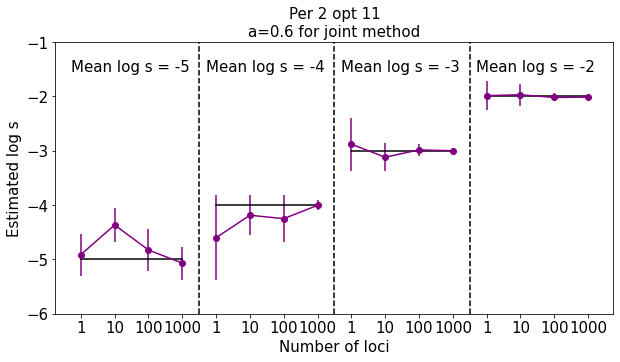

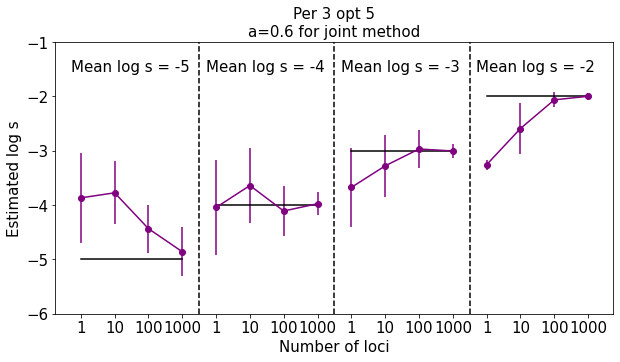

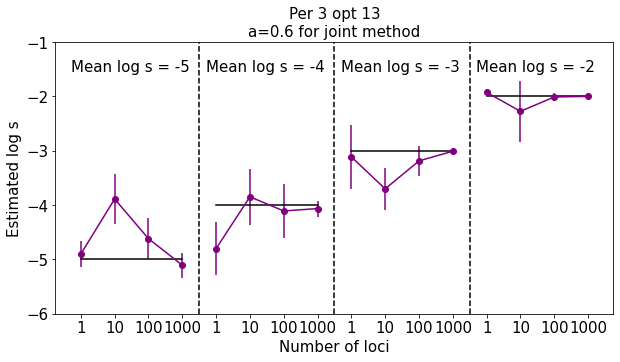

CPU times: user 8.44 s, sys: 755 ms, total: 9.2 s
Wall time: 9.45 s


In [4]:
%%time
if __name__ == '__main__':
    main()